In [1]:
import torch
from transformers import BertModel, BertTokenizerFast

from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Preprocessing

In [3]:
df = pd.read_csv("sites_out_only_text.csv", encoding="utf-8")
df = df.drop(labels="Unnamed: 0", axis=1)
df

url_host  \
0                  http://yandex.ru   
1                     http://vk.com   
2     http://avatars.mds.yandex.net   
3                 http://ad.mail.ru   
4               http://yastatic.net   
...                             ...   
7259      http://park.sokolniki.com   
7260             http://srgazeta.ru   
7261          http://info-effect.ru   
7262          http://neprizyvnoi.ru   
7263             http://wik-end.com   

                                                  title  \
0                                                Яндекс   
1                Мобильная версия ВКонтакте | ВКонтакте   
2                                                   NaN   
3     Рекламная платформа myTarget — Сервис таргетир...   
4                                                Яндекс   
...                                                 ...   
7259                                  Парк «Сокольники»   
7260                            Стерлитамакский рабочий   
7261  info-effect.ru — Инструкции для интернет польз...   
7262  Все об армии и призыве: информационная помощь ...   
7263  Новости Твери и Тверской области - информацион...   

                                                    tod  
0                                          Найдётся всё  
1     ВКонтакте – универсальное средство для общения...  
2                               410 Gone 410 Gone nginx  
3     Рекламная платформа myTarget — Сервис таргетир...  
4                                          Найдётся всё  
...                                                 ...  
7259                                  Парк «Сокольники»  
7260     «Стерлитамакский рабочий», \r\n г. Стерлитамак  
7261  info-effect.ru — Инструкции для интернет польз...  
7262  Все об армии и призыве: информационная помощь ...  
7263  Информационный портал Weekend-Тверь - всегда с...  

[7264 rows x 3 columns]

In [4]:
temp = df["title"].isin(["Just a moment...", "Player", "Error 404 (Not Found)!!1", "DDoS-Guard", "Главная", "Not Found", " 401", "Access denied", "Главная страница", "Access Blocked", "Подождите, мы подбираем зеркало для вас...", "Attention Required! | Cloudflare", np.nan])
df.loc[temp, "title"] = df.loc[temp, "tod"]
df

url_host  \
0                  http://yandex.ru   
1                     http://vk.com   
2     http://avatars.mds.yandex.net   
3                 http://ad.mail.ru   
4               http://yastatic.net   
...                             ...   
7259      http://park.sokolniki.com   
7260             http://srgazeta.ru   
7261          http://info-effect.ru   
7262          http://neprizyvnoi.ru   
7263             http://wik-end.com   

                                                  title  \
0                                                Яндекс   
1                Мобильная версия ВКонтакте | ВКонтакте   
2                               410 Gone 410 Gone nginx   
3     Рекламная платформа myTarget — Сервис таргетир...   
4                                                Яндекс   
...                                                 ...   
7259                                  Парк «Сокольники»   
7260                            Стерлитамакский рабочий   
7261  info-effect.ru — Инструкции для интернет польз...   
7262  Все об армии и призыве: информационная помощь ...   
7263  Новости Твери и Тверской области - информацион...   

                                                    tod  
0                                          Найдётся всё  
1     ВКонтакте – универсальное средство для общения...  
2                               410 Gone 410 Gone nginx  
3     Рекламная платформа myTarget — Сервис таргетир...  
4                                          Найдётся всё  
...                                                 ...  
7259                                  Парк «Сокольники»  
7260     «Стерлитамакский рабочий», \r\n г. Стерлитамак  
7261  info-effect.ru — Инструкции для интернет польз...  
7262  Все об армии и призыве: информационная помощь ...  
7263  Информационный портал Weekend-Тверь - всегда с...  

[7264 rows x 3 columns]

In [5]:
from fe_modules.site_embeddings import LaBSEWrapper

In [6]:
text_features = df["title"].to_list()

### Getting embeddings

In [7]:
model = LaBSEWrapper()
output = model(text_features, batch_size=16)

  0%|          | 0/454 [00:00<?, ?it/s]

### Visualization

In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#### TSNE-2d

In [9]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(output.cpu())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7264 samples in 0.005s...
[t-SNE] Computed neighbors for 7264 samples in 2.473s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7264
[t-SNE] Computed conditional probabilities for sample 2000 / 7264
[t-SNE] Computed conditional probabilities for sample 3000 / 7264
[t-SNE] Computed conditional probabilities for sample 4000 / 7264
[t-SNE] Computed conditional probabilities for sample 5000 / 7264
[t-SNE] Computed conditional probabilities for sample 6000 / 7264
[t-SNE] Computed conditional probabilities for sample 7000 / 7264
[t-SNE] Computed conditional probabilities for sample 7264 / 7264
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.868202
[t-SNE] KL divergence after 1000 iterations: 2.050020


C:\Users\home\AppData\Local\Temp\ipykernel_11500\1141397008.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

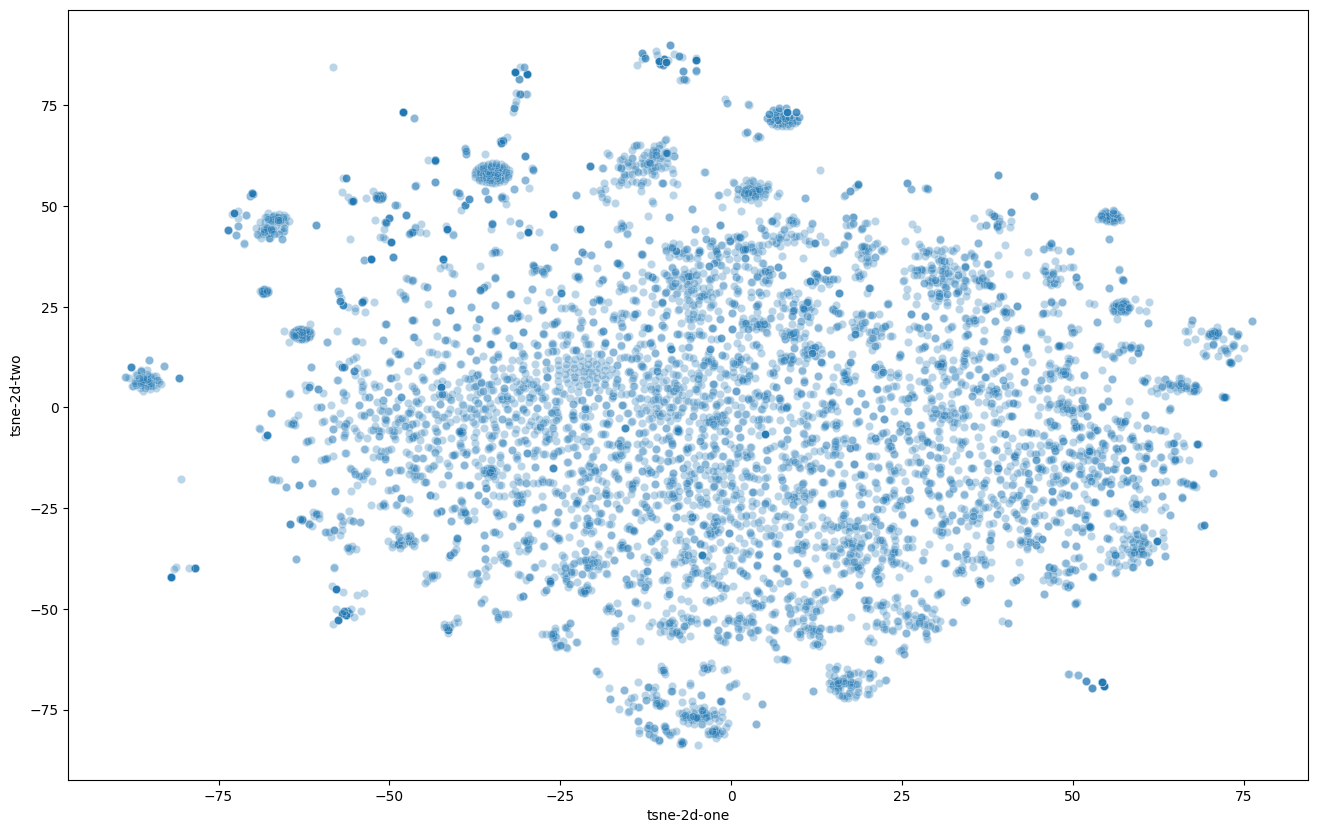

In [10]:
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

#### TSNE-3d

In [11]:
tsne = TSNE(n_components=3, verbose=1, perplexity=30, random_state=42)
projections = tsne.fit_transform(output.cpu())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7264 samples in 0.007s...
[t-SNE] Computed neighbors for 7264 samples in 1.945s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7264
[t-SNE] Computed conditional probabilities for sample 2000 / 7264
[t-SNE] Computed conditional probabilities for sample 3000 / 7264
[t-SNE] Computed conditional probabilities for sample 4000 / 7264
[t-SNE] Computed conditional probabilities for sample 5000 / 7264
[t-SNE] Computed conditional probabilities for sample 6000 / 7264
[t-SNE] Computed conditional probabilities for sample 7000 / 7264
[t-SNE] Computed conditional probabilities for sample 7264 / 7264
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.892487
[t-SNE] KL divergence after 1000 iterations: 1.843307


In [12]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2
)
fig.update_traces(marker_size=2)
fig.show()

#### PCA-2d

In [18]:
pca = PCA(n_components=2, random_state=42)
pca_results = pca.fit_transform(output.cpu())

C:\Users\home\AppData\Local\Temp\ipykernel_11500\3955699732.py:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<AxesSubplot: xlabel='pca-2d-one', ylabel='pca-2d-two'>

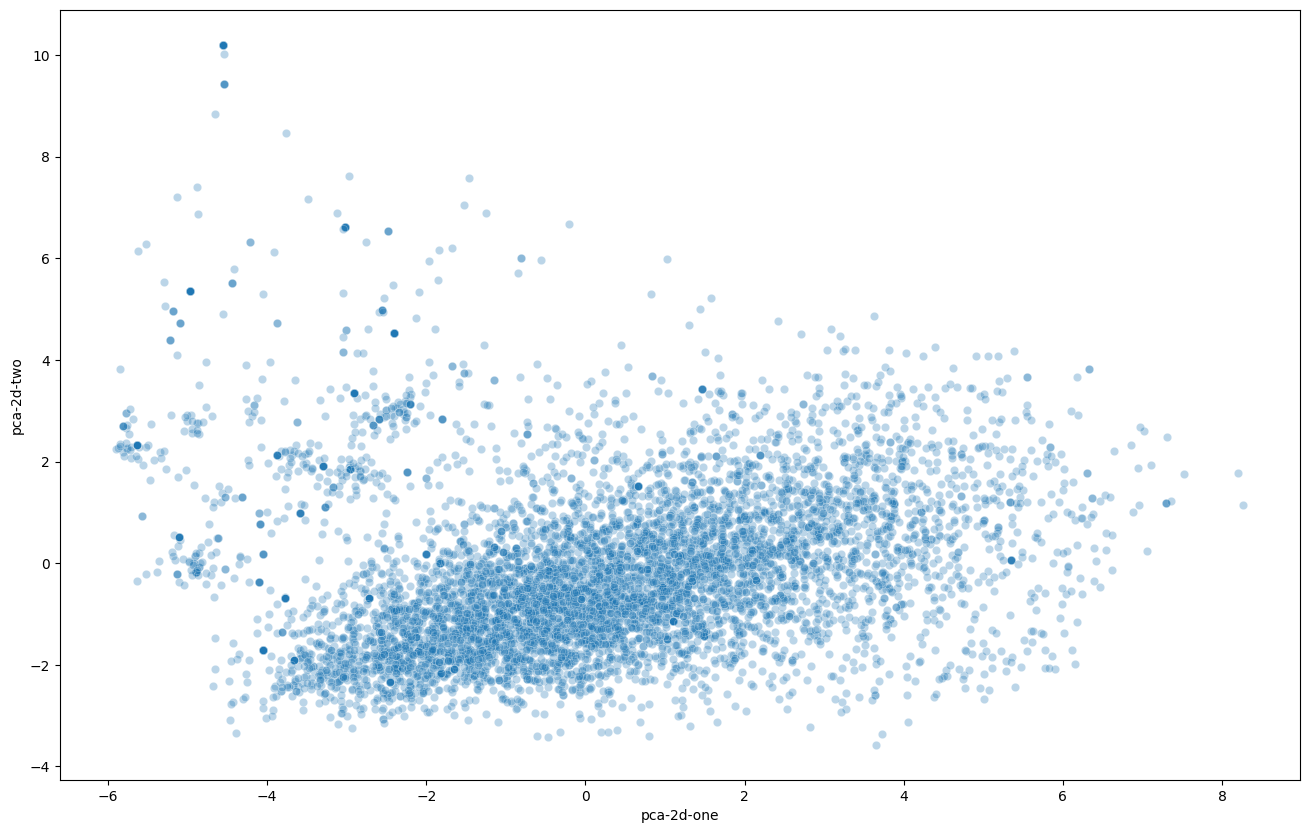

In [19]:
df_subset = pd.DataFrame()
df_subset['pca-2d-one'] = pca_results[:,0]
df_subset['pca-2d-two'] = pca_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

#### PCA-3d

In [23]:
pca = PCA(n_components=3, random_state=42)
projections = pca.fit_transform(output.cpu())

In [24]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2
)
fig.update_traces(marker_size=2)
fig.show()

#### TruncatedSVD-2d

In [20]:
svd = TruncatedSVD(n_components=2, random_state=42)
svd_results = svd.fit_transform(output.cpu())

C:\Users\home\AppData\Local\Temp\ipykernel_11500\2250857695.py:6: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



<AxesSubplot: xlabel='svd-2d-one', ylabel='svd-2d-two'>

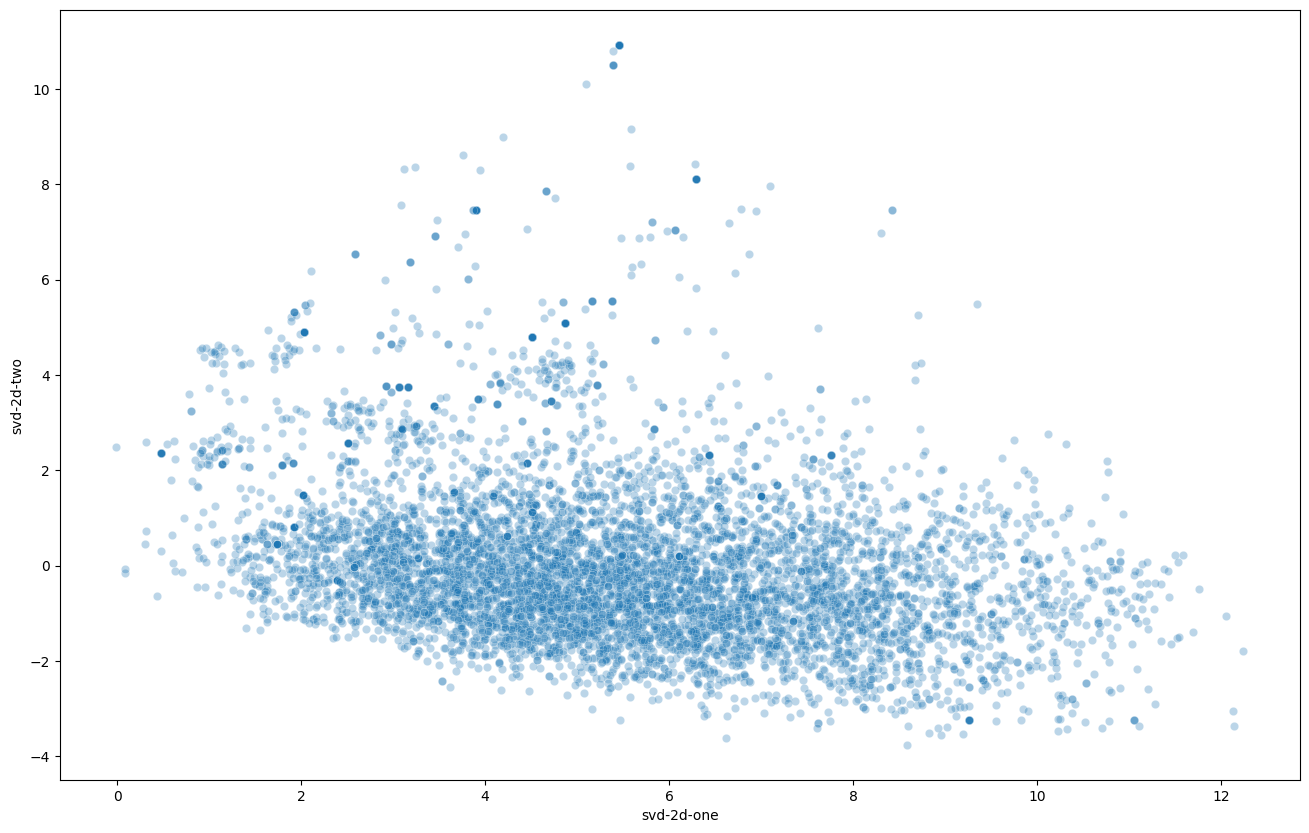

In [21]:
df_subset = pd.DataFrame()
df_subset['svd-2d-one'] = svd_results[:,0]
df_subset['svd-2d-two'] = svd_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="svd-2d-one", y="svd-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

#### TruncatedSVD-3d

In [25]:
svd = TruncatedSVD(n_components=3, random_state=42)
projections = svd.fit_transform(output.cpu())

In [26]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2
)
fig.update_traces(marker_size=2)
fig.show()